### veg_sensitivity_testing_NPVintegration_maskingissue

using monthly aggregates with consecutive counting but trying to solve masking issue within function


In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', None)
dc = datacube.Datacube(app="veg_sensitivity")

from numba import jit

In [2]:
# # 13, -28 (Central west QLD, 2010 veg, 2015 bare)
# x = (1300000, 1350000)
# y = (-2750000, -2700000)

# # 13, -28 (Central west QLD, 2010 veg, 2015 bare) not square
# x = (1300000, 1325000)
# y = (-2750000, -2700000)

# 11, -48 (Southwest Tassie, 2010 veg 2015, bare 2015 - should be all veg/water, problem with obs count)
x = (1150000, 1200000)
y = (-4700000, -4750000)

# # -1, -28 (Uluru)
# x = (-100000, -90000)
# y = (-2737500, -2747500)

# # small area not square
# x = (1101550, 1101650)
# y = (-3970125, -3970175)

res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")

query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

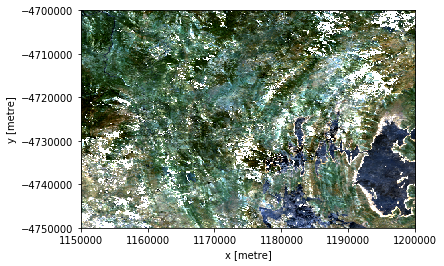

In [3]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

#### create the same virtual product as vegetat_veg_cat

In [4]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
catalog = catalog_from_file('./virtual_product_cat_veg_testing.yaml')

In [5]:
# # load from datacube virtual product
# product = catalog['vegetat_veg_cat']
# can remove ls7 if not wanted
product = catalog['vegetat_veg_cat_ls7removed']
data = product.load(dc, **query)

### FIX: have we got the masking of no data correct?
- we have not, need to make sure no data values are keep as `nan` and not defaulting to false when using boolean
- try to avoid using boolean will sort this out
- however I think input to classify level 3 currently requires boolean
- <font color='red'> Need `consecutive_count` function to retain nan if all pixels in time series are nan </font>


In [15]:
# aggregate to monthly data
data_month = data.groupby('time.month').max(dim='time')

# run pluging rules, including NPV #
# Create mask where BS < PV
tv_mask_PV = data_month['BS'] <= data_month['PV']
tv_mask_PV_nan = tv_mask_PV.where((data_month['BS'] > 0) & (data_month['PV'] > 0))

# Create mask where BS < NPV
tv_mask_NPV = data_month['BS'] <= data_month['NPV']
tv_mask_NPV_nan = tv_mask_NPV.where((data_month['BS'] > 0) & (data_month['NPV'] > 0))

# Veg where PV or NPV are greater than BS
# need to keep nans - probs a better way of doing this but works for now
tv_mask = (tv_mask_PV_nan + tv_mask_NPV_nan)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask_xr.where((data_month['water'] != 128), 0)
tv = tv_mask_xr.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)

In [16]:
# need to change to ouput map that gives nan but still operates on count

def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series
    
    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''
    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            # FIXME: Chris - is that what is needed?
            if np.all(np.isnan(tv_numpy[:,y,x])):
                consecutive_numpy[y,x] = np.nan
                continue
            # num_consecutive set to 1 as if statement below requires looking at previous value
            # therefore cannot use required_consecutive=1, however not a problem
            # as we wouldn't want to know anything >=2 for required_consecutive
            num_consecutive = 1
            max_num_consecutive = 0
            # Go through all dates looking for consecutive values
            for z in range(1, tv_numpy.shape[0]):
                # If value is the same as previous date and same as consec_msk_val
                # iterate number of consecutive
                if (tv_numpy[z-1,y,x] == tv_numpy[z,y,x]) and (tv_numpy[z,y,x] == consec_msk_val):
                    num_consecutive += 1
                    if num_consecutive > max_num_consecutive:
                        max_num_consecutive = num_consecutive
                # If not reset counter
                else:
                    num_consecutive = 1
            # If there enough consecutive 1's for required_consecutive
            # Set output to veg (1)
            if max_num_consecutive >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                 consecutive_numpy[y,x] = 0
    return consecutive_numpy

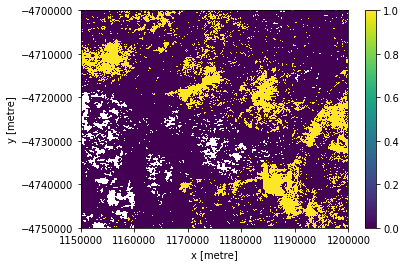

In [17]:
# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()